In [1]:
import json
import pandas as pd

In [2]:
def parse(message, begin, end):
    """
    This function parses a message to find all substrings between
    a given begin_token and end_token.

    Args:
        message: The message to be parsed.
        begin_token: The starting token (inclusive).
        end_token: The ending token (inclusive).

    Returns:
        A list of all substrings found between the begin_token and end_token.
    """
    substrings = []
    start_index = 0
    while True:
        begin_loc = message.find(begin, start_index)
        if begin_loc == -1:
            break
        end_loc = message.find(end, begin_loc + len(begin))
        if end_loc == -1:
            end_loc = len(message)
        offset = 0
        if message[begin_loc + len(begin)] ==":":
            offset=1
        substring = message[begin_loc + len(begin)+offset:end_loc]
        substrings.append(substring)
        start_index = end_loc + len(end)
    return substrings

In [46]:
results = pd.read_csv("/home/djeddal/Documents/Code/Attributed-IR/results/RTG_vanilla/generation_RTG_vanilla_2_passages.csv",converters={"docids":eval,"docs_text":eval,"gold_truth":eval,"gold_quotes":eval,"sub_queries":eval,"answers":eval,"quotes":eval})

adjust GTR

In [30]:
import re

def reposition_period(text):
    # Regular expression to find ". [number]"
    pattern = re.compile(r'\.\s*\[\s*(\d+)\s*\]')
    # Replace with "[number] ."
    replaced_text = pattern.sub(r' [\1] .', text)
    return replaced_text

# Example usage
text = "This is a sentence. [1] Another sentence. [2] Yet another sentence. [10]"
print(reposition_period(text))

answers_with_citation = []
all_docs =[]
for _,row in results.iterrows():
    answer = ""
    docs = []
    for q in row["sub_queries"]:
        citedanswer = reposition_period(q["sub_query"] + " ["+str(len(docs)+1)+"] ")
        docs.append(q["retrieved_passages"][0])
        answer += citedanswer
    answers_with_citation.append(answer)
    all_docs.append(docs)
    
results["output"] = answers_with_citation
results["docs"] = all_docs
        

This is a sentence [1] . Another sentence [2] . Yet another sentence [10] .


In [47]:
results.iloc[0]

query                   Where did Jehovah's Witnesses originate?
output         Jehovah's Witnesses originated from the Intern...
gold_truth     [{'answer': 'Jehovah's Witnesses originated as...
quotes         [{'docid': '13949533#3', 'text': 'Jehovah's Wi...
gold_quotes    [{'idx': 1, 'docid': '13949533#3', 'text': 'Je...
Name: 0, dtype: object

In [35]:
results["docs"][0]

[{'idx': 1,
  'docid': '3897876#0',
  'text': 'Jehovah\'s Witnesses originated as a branch of the Bible Student movement, which developed in the United States in the 1870s among followers of Christian Restorationist minister Charles Taze Russell. Bible Student missionaries were sent to England in 1881 and the first overseas branch was opened in London in 1900. The group took on the name International Bible Students Association and by 1914 it was also active in Canada, Germany, Australia and other countries. The movement split into several rival organizations after Russell\'s death in 1916, with one—led by Russell\'s successor, Joseph "Judge" Rutherford—retaining control of both his magazine, "The Watch Tower", and his legal and publishing corporation, the Watch Tower Bible and Tract Society of Pennsylvania.'},
 {'idx': 1,
  'docid': '2875347#2',
  'text': 'On February 16, 1881, Zion\'s Watch Tower Tract Society was formed in Pittsburgh, Pennsylvania, United States, for the purpose of o

In [23]:
len(results["sub_queries"][0][0]["retrieved_passages"])

5

In [ ]:
results["sub_queries"][0]

In [18]:
eval(results["quotes"][0])

[{'idx': 1,
  'docid': '498796#93',
  'text': 'Jehovah\'s Witnesses comprise a fast-growing denomination that has kept itself separate from other Christian denominations. It began in 1872 with Charles Taze Russell, but experienced a major schism in 1917 as Joseph Franklin Rutherford began his presidency. Rutherford gave new direction to the movement and renamed the movement "Jehovah\'s witnesses" in 1931. The period from 1925 to 1933 saw many significant changes in doctrine. Attendance at their yearly Memorial dropped from a high of 90,434 in 1925 to 63,146 in 1935. Since 1950 growth has been very rapid.'},
 {'idx': 2,
  'docid': '13949533#3',
  'text': "Jehovah's Witnesses were an outgrowth of the International Bible Students, who began missionary work in Europe in the 1890s. A German branch office of the Watch Tower Society opened in Elberfeld in 1902. By 1933, almost 20,000 Witnesses were counted as active door-to-door preachers, and their annual Memorial service was attracting almo

In [3]:
#### ALCE
file="/home/djeddal/Documents/Code/results/7b_rag_adjusted_webgptTrain/asqa/all_testasqa_7b_finetunedAdjustedAgentWG_4rounds_3docs.json" #"/home/djeddal/Documents/Code/llm-agent/results_hagrid_training_v0/agent_alce_asqa_3doc_5rounds_trainH.json"
with open(file) as f:
    data_with_config = json.load(f)
results = pd.json_normalize(data_with_config["data"])

In [9]:
#### ALCE
file="/home/djeddal/Documents/Code/results/llama_7b_normal_hagridTrain/asqaTest/all_llama_testasqa_7b_finetunedSimpleAgenHagrid_4rounds_3docs.json" #"/home/djeddal/Documents/Code/llm-agent/results_hagrid_training_v0/agent_alce_asqa_3doc_5rounds_trainH.json"
with open(file) as f:
    results = json.load(f)
#results = pd.json_normalize(data_with_config["data"])

#### stats on generated suqueries

In [67]:
results["len_generated_queries"] = results["generated_text"].apply(lambda x : len(parse(x,"[SEARCH]", "[/SEARCH]")))

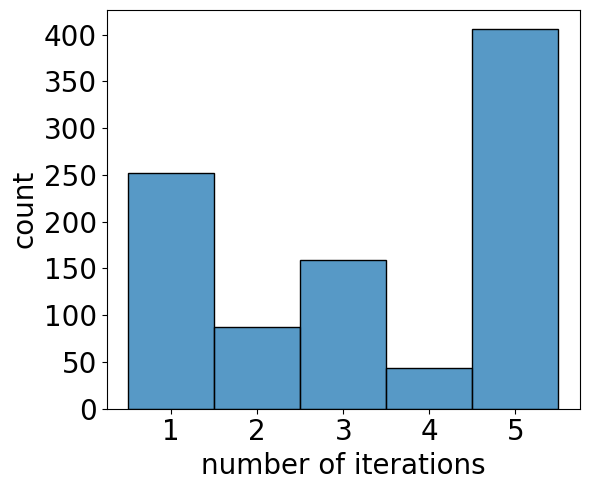

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
#results.index = metric_df.index + 1
ax = sns.histplot(
        data=results,
        x="len_generated_queries",
        discrete=True
    )
# marker_size = 10  # Adjust marker size as needed
# for line in ax.get_lines():
#     line.set_markersize(marker_size)
plt.xlabel(f'number of iterations', fontsize=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.ylabel("count",size=20)
#plt.legend(fontsize=12, loc="right",bbox_to_anchor=(1,0.7))
# loc="upper left", bbox_to_anchor=(1.05, 1)
plt.tight_layout()
plt.show()

<Axes: >

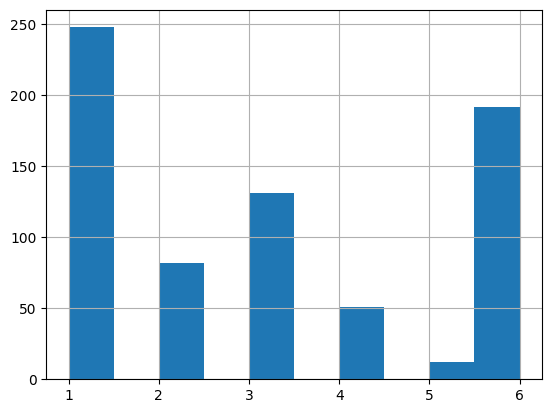

In [6]:
results["len_generated_queries"].hist()

### file adjust

docs list of list to list

In [4]:
results["data"][0]

{'qa_pairs': [{'context': 'No context provided',
   'question': "Who has the highest goals in men's world international football?",
   'short_answers': ['Daei', 'Ali Daei'],
   'wikipage': None},
  {'context': 'No context provided',
   'question': "Who has the highest goals all-time in men's football?",
   'short_answers': ['Bican', 'Josef Bican'],
   'wikipage': None},
  {'context': 'The first player to reach 100 international goals was Italian Elisabetta Vignotto. Abby Wambach scored 100 goals in 9 years, while Christine Sinclair reached the milestone in just under 10 years while Mia Hamm is the youngest player to score 100 international goals at the age of 26 years 185 days. Most played exclusively in the forward position, with Kristine Lilly and Michelle Akers having also played as midfielder. All players scored at a high average rate of more than one goal every three matches. International goals in this list should not include goals scored in penalty-shoot-out; see Penalty shootou

In [12]:
json_dict = {}
data = []
for item in results["data"]:
    docs = []
    docids = []
    for statement_docs in item["docs"]:
        for doc in statement_docs:
            docid = doc["docid"]
            if docid not in docids:
                docs.append(doc)
                docids.append(docid)
    output=  item["output"]
    for i in range(len(docs)):
        if docs[i]["docid"] in output:
            output = output.replace(docs[i]["docid"],str(i+1))
    item_ditct= item
    item_ditct["docs"] =  docs
    
    item_ditct["output"] =  output
    data.append(item_ditct)
json_dict["data"] = data

In [13]:
json_dict["data"][0]

{'qa_pairs': [{'context': 'No context provided',
   'question': "Who has the highest goals in men's world international football?",
   'short_answers': ['Daei', 'Ali Daei'],
   'wikipage': None},
  {'context': 'No context provided',
   'question': "Who has the highest goals all-time in men's football?",
   'short_answers': ['Bican', 'Josef Bican'],
   'wikipage': None},
  {'context': 'The first player to reach 100 international goals was Italian Elisabetta Vignotto. Abby Wambach scored 100 goals in 9 years, while Christine Sinclair reached the milestone in just under 10 years while Mia Hamm is the youngest player to score 100 international goals at the age of 26 years 185 days. Most played exclusively in the forward position, with Kristine Lilly and Michelle Akers having also played as midfielder. All players scored at a high average rate of more than one goal every three matches. International goals in this list should not include goals scored in penalty-shoot-out; see Penalty shootou

#### baselines

In [48]:
json_dict = {}
data = []
for _,item in results.iterrows():
    output = item["output"]#item["generated_text"]
    docs = item["quotes"] #eval(item["quotes"])
    item_ditct={}
    item_ditct["question"] =item["query"]
    item_ditct["output"] =  output
    item_ditct["docs"] =  docs
    item_ditct["gold_quotes"] =  item["quotes"]#item["gold_quotes"]
    item_ditct["gold_truth"] =  item['gold_truth']#item["gold_truth"]
    item_ditct["answer"] = item["gold_truth"][0]["answer"]# item["gold_truth"][0]["answer"]
    ### adding the different gold answers
    item_ditct["annotations"] = []
    for a in item["gold_truth"]: #item["gold_truth"]:
        item_ditct["annotations"].append({"long_answer":a["answer"]})
    if len(item_ditct["annotations"]) < 2:
        item_ditct["annotations"].append({"long_answer":a["answer"]})
    data.append(item_ditct)
json_dict["data"] = data

In [ ]:
json_dict = {}
data = []
for _,item in results.iterrows():
    output = " ".join(parse(item["generated_text"], '[ANSWER]', '[/ANSWER]'))
    docs = []
    docids = []
    for statement_docs in item["docs_text"]:
        for d in statement_docs:
            doc = eval(d)
            docid = doc["docid"]
            if docid not in docids:
                docs.append(doc)
                docids.append(docid)
    #### replace docids in answer by indices
    for i in range(len(docs)):
        if docs[i]["docid"] in output:
            output = output.replace(docs[i]["docid"],str(i+1))
    item_ditct={}
    item_ditct["question"] =item["query"]
    item_ditct["output"] =  output
    item_ditct["docs"] =  docs
    item_ditct["gold_quotes"] =  item["gold_quotes"]
    item_ditct["gold_truth"] =  item["gold_truth"]
    item_ditct["answer"] = item["gold_truth"][0]["answer"]
    ### adding the different gold answers
    item_ditct["annotations"] = []
    for a in item["gold_truth"]:
        item_ditct["annotations"].append({"long_answer":a["answer"]})
    if len(item_ditct["annotations"]) < 2:
        item_ditct["annotations"].append({"long_answer":a["answer"]})
    data.append(item_ditct)
json_dict["data"] = data


In [49]:
with open("/home/djeddal/Documents/Code/Attributed-IR/results/RTG_vanilla/generation_RTG_vanilla_2_passages_corrected.json", "w") as writer:
    json.dump(json_dict, writer)

## rag agent

In [ ]:
import re 
pattern = r"<\|system\|>[\s\S]*?<\|assistant\|>\n"
file= "/home/djeddal/Documents/Code/results/7b_rag_simple_hagridTrain/Testhagrid/without_ret/all_testHagrid_7b_finetunedSimpleAgenHagrid_v2_8rounds_0docs.json"
#"/home/djeddal/Documents/Code/results/results_rag_7b_hagrid/all_testHagrid_7b_finetunedAdjustedAgenHagrid.json"
#"/home/djeddal/Documents/Code/results/results_rag_7b_hagrid/all_testHagrid_7b_finetunedSimpleAgenHagrid.json"#"/home/djeddal/Documents/Code/results/3b_rag_adjusted_hagridTrain_hgridTest/all_testHagrid_3b_finetunedAdjustedAgenHagrid_v2.json"
with open(file) as f:
    data_with_config = json.load(f)
    for row in data_with_config["data"]:
        if row["output"] ==  None:
            print("None")
            output = re.sub(pattern,"",row["generated_text"])
            print(output)
            row["output"] = output
results = pd.json_normalize(data_with_config["data"])

### Split Rounds

In [35]:
import re 
pattern = r"<\|system\|>[\s\S]*?<\|assistant\|>\n"
file= "/home/djeddal/Documents/Code/results/7b_rag_simple_hagridTrain/Testhagrid/params/all_testHagrid_7b_finetunedSimpleAgenHagrid_v2_12rounds_1docs.json"
#"/home/djeddal/Documents/Code/results/results_rag_7b_hagrid/all_testHagrid_7b_finetunedAdjustedAgenHagrid.json"
#"/home/djeddal/Documents/Code/results/results_rag_7b_hagrid/all_testHagrid_7b_finetunedSimpleAgenHagrid.json"#"/home/djeddal/Documents/Code/results/3b_rag_adjusted_hagridTrain_hgridTest/all_testHagrid_3b_finetunedAdjustedAgenHagrid_v2.json"
with open(file) as f:
    data_with_config = json.load(f)
    for row in data_with_config["data"]:
        output = parse(row["generated_text"],"[ANSWER]","[/ANSWER]")
        if output:
            row["output"] = " ".join(output[:12])
        else:
            print("None")
            output = re.sub(pattern,"",row["generated_text"])
            print(output)
            row["output"] = output

results = pd.json_normalize(data_with_config["data"])

None
<|user|>
What are some ways to keep yourself motivated?</s> 
<|assistant|>
1. Set specific goals: Setting specific, achievable goals can help you stay focused and motivated. Make sure your goals are challenging but not impossible to achieve.

2. Break down big goals into smaller ones: If you have a big goal, break it down into smaller, more manageable steps. This can make it easier to stay motivated and see progress.

3. Create a plan: Once you have your goals and smaller steps, create a plan to achieve them. This can help you stay organized and focused.

4. Celebrate small wins: Celebrate your progress along the way, no matter how small. This can help you stay motivated and build momentum.

5. Find an accountability partner: Find someone who can hold you accountable and support you along the way. This can be a friend, family member, or coach.

6. Visualize success: Take some time to visualize what success looks like for you. This can help you stay motivated and focused on your go

In [21]:
results["output"][80]

' The Arabic numerals were not adopted as a new system in Europe, as they were already known and used there since the 10th century.   The Arabic numerals were introduced to Europe through the works of Muslim scholars who translated and shared their knowledge with European scholars. This exchange began in Spain, and the Arabic numerals were then widely adopted throughout Europe due to their ease of use in computations. '

In [4]:
eval(results["docs"][0][0][0])

{'docid': '34284695#0',
 'title': "Jehovah's Witnesses beliefs",
 'text': 'The beliefs of Jehovah\'s Witnesses are based on the Bible teachings of Charles Taze Russell—founder of the Bible Student movement—and successive presidents of the Watch Tower Society, Joseph Franklin Rutherford, and Nathan Homer Knorr. Since 1976 all doctrinal decisions have been made by the Governing Body of Jehovah\'s Witnesses, a group of elders at the group\'s Warwick, New York headquarters. These teachings are disseminated through "The Watchtower" magazine and other publications of Jehovah\'s Witnesses, and at conventions and congregation meetings.'}

In [17]:
# json_dict = {}
# data = []
# for _,item in results.iterrows():
#     output = item["output"]
#     docs = []
#     docids = []
#     for statement_docs in item["docs"]:
#         for doc in statement_docs:
#             d = eval(doc)
#             docid = d["docid"]
#             if docid not in docids:
#                 docs.append(d)
#                 docids.append(docid)
#     #### replace docids in answer by indices
#     for i in range(len(docs)):
#         if docs[i]["docid"] in output:
#             output = output.replace(docs[i]["docid"],str(i+1))
#     item_ditct= {}
#     item_ditct["question"] =item["question"]
#     item_ditct["output"] =  output
#     item_ditct["docs"] =  docs
#     item_ditct["gold_quotes"] =  item["gold_quotes"]
#     item_ditct["gold_truth"] =  item["gold_truth"]
#     item_ditct["answer"] = item["gold_truth"][0]["answer"]
#     ### adding the different gold answers
#     item_ditct["annotations"] = []
#     for a in item["gold_truth"]:
#         item_ditct["annotations"].append({"long_answer":a["answer"]})
#     if len(item_ditct["annotations"]) < 2:
#         item_ditct["annotations"].append({"long_answer":a["answer"]})
#     data.append(item_ditct)
# json_dict["data"] = data

In [22]:
import re

def reposition_period(text):
    # Regular expression to find ". [number]"
    pattern = re.compile(r'\.\s*\[\s*(\d+)\s*\]')
    # Replace with "[number] ."
    replaced_text = pattern.sub(r' [\1] .', text)
    return replaced_text

# Example usage
text = "This is a sentence. [1] Another sentence. [2] Yet another sentence. [10]"
print(reposition_period(text))

This is a sentence [1] . Another sentence [2] . Yet another sentence [10] .


In [36]:
json_dict = {}
data = []
for _,item in results.iterrows():
    output = item["output"]
    docs = []
    docids = []
    for statement_docs in item["docs"]:
        for doc in statement_docs:
            d = eval(doc)
            docid = d["docid"]
            if docid not in docids:
                docs.append(d)
                docids.append(docid)
    #### replace docids in answer by indices
    for i in range(len(docs)):
        if docs[i]["docid"] in output:
            output = output.replace(docs[i]["docid"],str(i+1))
    item_ditct=item.to_dict()
    #item_ditct["question"] =item["question"]
    item_ditct["output"] =  reposition_period(output)
    item_ditct["docs"] =  docs
    item_ditct.pop("generated_text")
    #item_ditct["gold_quotes"] =  item["gold_quotes"]
    #item_ditct["gold_truth"] =  item["gold_truth"]
    #item_ditct["answer"] = item["gold_truth"][0]["answer"]
    ### adding the different gold answers
    #item_ditct["annotations"] = []
    #for a in item["gold_truth"]:
    #    item_ditct["annotations"].append({"long_answer":a["answer"]})
    #if len(item_ditct["annotations"]) < 2:
    #    item_ditct["annotations"].append({"long_answer":a["answer"]})
    data.append(item_ditct)
json_dict["data"] = data

In [7]:
json_dict

{'data': [{'question': "Where did Jehovah's Witnesses originate?",
   'generated_text': "<|user|>\nWhere did Jehovah's Witnesses originate?</s>      \n<|assistant|>\n [SEARCH]What is the origin of Jehovah's Witnesses?[/SEARCH]\n[ANSWER]: Jehovah's Witnesses originated in the 1870s in Allegheny, Pennsylvania, with the Bible study group formed by Charles Taze Russell and his associates.[/ANSWER]\n</s>    \n<|user|>\nCan you provide more information on the history of Jehovah's Witnesses and their beliefs?</s>   \n<|assistant|> [SEARCH]What are the key beliefs of Jehovah's Witnesses?[/SEARCH]\n[ANSWER]: Their beliefs include interpretations of the second coming of Christ, the millennium, and the kingdom of God [158849#1].[/ANSWER]\n</s> \n<|user|>\nCan you provide more details on the origins of Jehovah's Witnesses and how they came to be known by that name?</s>",
   'output': " Jehovah's Witnesses originated in the 1870s in Allegheny, Pennsylvania, with the Bible study group formed by Char

In [24]:
json_dict["data"][0]["output"]

" Jehovah's Witnesses originated from the Bible Students movement, which was founded by Charles Taze Russell in the late 1800s [1] .   In 1931, the Bible Students became known as Jehovah's Witnesses under the leadership of Joseph Franklin Rutherford of the Watch Tower Bible and Tract Society [2] .   However, it is important to note that some sources consider Jehovah's Witnesses as a religious cult that originated from the Bible Students movement [3] . "

In [13]:
len(json_dict["data"])

716

In [ ]:
json_dict["data"][100]

In [14]:
with open("/home/djeddal/Documents/Code/results/llama_7b_normal_hagridTrain/asqaTest/all_llama_testasqa_7b_finetunedSimpleAgenHagrid_4rounds_3docs.json", "w") as writer:
    json.dump(json_dict, writer)

In [89]:
df = pd.read_csv("/home/djeddal/Documents/Code/llm-agent/agent_hagrid_3doc_3rounds.csv", index_col=0,converters={"docs":eval,"gold_truth":eval,"annotations":eval,"gold_quotes":eval})

In [90]:
data = df.to_dict('records')

In [92]:
print(data[2]["generated_text"])

<|user|>
When did the movie Scott Pilgrim come out?</s>   
<|assistant|>
[SEARCH] What year was the movie Scott Pilgrim vs. The World released?[/SEARCH]
[DOCS] [{'docid': '1', 'title': 'Scott Pilgrim', 'text': 'The film "Scott Pilgrim vs. the World" was released on August 13, 2010. It is based on all six volumes of the graphic novel series, despite the different ending due to the sixth volume having been released after the film finished shooting. The film is directed by Edgar Wright and stars Michael Cera and Mary Elizabeth Winstead as Scott and Ramona, respectively.'}, {'docid': '2', 'title': "Bryan Lee O'Malley", 'text': 'The film adaptation of his "Scott Pilgrim" series, "Scott Pilgrim vs. the World", directed and co-written by Edgar Wright, was released by Universal Pictures on August 13, 2010.'}, {'docid': '3', 'title': 'Edgar Wright', 'text': 'In 2010, "Scott Pilgrim vs. the World" was released; its over-$85 million budget dwarfed the £8 million budget of "Hot Fuzz". The film, ba

sol 1 : no end answer

In [40]:
import numpy as np
for i in range(len(data)):
    data[i]["question"] =data[i]["query"]
    del data[i]["query"]
    if isinstance(data[i]["output"], float):
        position = data[i]["generated_text"].find('[ANSWER]')

        if position != -1:
            # Calculate the starting position of the text after the special_string
            start = position + len('[ANSWER]')
            # Extract all the text after the special_string
            data[i]["output"] = data[i]["generated_text"][start:]

sol 2 : cas particulier

In [86]:
import re
for i in range(len(data)):
    data[i]["question"] =data[i]["query"]
    del data[i]["query"]
    if i== 667:
        data[i]["output"] = " ".join(parse(data[i]["generated_text"],"[ANSWER]","[/ANSWER"))
    if i == 75 :
        a = parse(data[i]["generated_text"],"[ANSWER]","[/ANSWER]")
        pattern1 = r'\[SEARCH\].*?\[\/SEARCH\]'
        pattern2 = r'\[DOCS\].*?\[\/DOCS\]'
        pattern3 = r'\[ANSWER\].*?\[\/ANSWER\]'
        result = re.sub(pattern1, '', a[0])
        result = re.sub(pattern2, '',result)
        result = re.sub(pattern3, '',result)
        result =result.replace("[ANSWER]","")
        data[i]["output"] = result

In [87]:
for i in range(len(data)):
    if isinstance(data[i]["output"], float):
        print(i,type(data[i]["output"]))

In [85]:
print(data[667]["generated_text"])

<|user|>
How many seasons does Canada's Worst Driver have?</s>   
<|assistant|>
[SEARCH] How many seasons of Canada's Worst Driver have been produced?[/SEARCH]
[DOCS] [{'docid': '1', 'title': "Canada's Worst Driver", 'text': 'Canada\'s Worst Driver is a Canadian television series on Discovery Channel, based on "Britain\'s Worst Driver" and is part of the Worst Driver television franchise. The series is produced by Proper Television, whose president, Guy O\'Sullivan, was the director of the original "Britain\'s Worst Driver" series until its cancellation in 2003. O\'Sullivan served as executive producer of "Canada\'s Worst Driver" until his death in April 2017, doubling as executive producer of sister series "Canada\'s Worst Handyman" until its cancellation in 2011. As such, "Canada\'s Worst Driver" is considered to be the production company\'s flagship show and, with 14 seasons aired as of December 2018, the longest-running of any "Worst" series to date. Unlike other "Worst" series aro

In [67]:
a = parse(data[667]["generated_text"],"[ANSWER]","[/ANSWER")
a

['Canada\'s Worst Driver is a Canadian television series on Discovery Channel, based on "Britain\'s Worst Driver" and is part of the Worst Driver television franchise. The series is produced by Proper Television, whose president, Guy O\'Sullivan, was the director of the original "Britain\'s Worst Driver" series until its cancellation in 2003. O\'Sullivan served as executive producer of "Canada\'s Worst Driver" until his death in April 2017, doubling as executive producer of sister series "Canada\'s Worst Handyman" until its cancellation in 2011. As such, "Canada\'s Worst Driver" is considered to be the production company\'s flagship show and, with 14 seasons aired as of December 2018, the longest-running of any "Worst" series to date. Unlike other "Worst" series around the world, where being a graduate is rewarded with a new car while the Worst Driver has their car destroyed, "Canada\'s Worst Driver" emphasizes the learning process of the contestants and the science of driving and is o

In [68]:
import re
a = parse(data[75]["generated_text"],"[ANSWER]","[/ANSWER]")
pattern1 = r'\[SEARCH\].*?\[\/SEARCH\]'
pattern2 = r'\[DOCS\].*?\[\/DOCS\]'
pattern3 = r'\[ANSWER\].*?\[\/ANSWER\]'
result = re.sub(pattern1, '', a[0])
result = re.sub(pattern2, '',result)
result = re.sub(pattern3, '',result)
result = result.replace("[ANSWER]","")
print(result)

There are many ways to keep yourself motivated, and the best strategies will depend on your specific situation and goals. Here are some general tips:

1. Set long-term goals: Long-term goals are important because they provide a sense of direction and purpose. They can also help you stay motivated when faced with obstacles or setbacks.

2. Break down your goals into smaller steps: This can help you stay focused and motivated by giving you a clear path to follow.

3. Focus on the process, not just the outcome: Instead of just focusing on the end result, focus on the steps you need to take to get there. This can help you stay motivated and focused on the present.

4. Find a support system: Whether it's a friend, family member, or a mentor, having someone to talk to and get advice from can help you stay motivated and focused on your goals.

5. Reward yourself: Celebrate your achievements along the way. This can help you stay motivated and focused on your goals.

6. Stay positive: Focus on 

In [88]:
json_dict={}
json_dict["data"] = data
with open("/home/djeddal/Documents/Code/llm-agent/agent_hagrid_3doc_3rounds.json", "w") as writer:
    json.dump(json_dict, writer)

In [26]:
df = pd.read_csv("/home/djeddal/Documents/Code/ALCE/zephyr_results/alce_asqa_5docs_rtg.csv",
            converters={
                "qa_pairs": eval,
                "wikipages": eval,
                "annotations": eval,
                "docs": eval,
            },
        )

In [7]:
print(df["output"][0])

Pelé has the highest goals in world football, with 1281 recognized by FIFA and 767 goals in official mode, according to the Soccer Statistic Foundation (rssf). [1] Maradona is considered the best soccer player in World Cup history by The Times and FourFourTwo, but the question is about the highest goals in football, not individual player rankings. [2] Godfrey Chitalu holds the world record of 116 goals in a single year, according to the Football Association of Zambia. However, FIFA does not keep statistical track of domestic competitions, so this record may not be officially recognized. [3] Vartan also holds the record for the highest all-time scorer in Lebanese football, with 130 goals. [4] Josef Bican is considered the most prolific scorer of all time, with at least 805 goals according to the Rec.Sport.Soccer Statistics Foundation (RSSSF). [5]


In [ ]:
pattern = r'. \[\s*\d+(?:,\s*\d+)*\s*\]'

In [4]:

import re

def reposition_period(text):
    # Regular expression to find ". [number]"
    pattern = re.compile(r'\.\s*\[\s*(\d+)\s*\]')
    # Replace with "[number] ."
    replaced_text = pattern.sub(r' [\1] .', text)
    return replaced_text

# Example usage
text = "This is a sentence. [1] Another sentence. [2] Yet another sentence. [10]"
print(reposition_period(text))
for index,row in df.iterrows():
    updated_text = reposition_period(row["output"])
    df.at[index, "output"]= updated_text

This is a sentence [1] . Another sentence [2] . Yet another sentence [10] .


NameError: name 'df' is not defined

In [27]:
print(df["output"][116])

Pee-wee Herman, a.k.a. Paul Reubens, played the character Cowboy Curtis on the CBS children's television show "Pee-wee's Playhouse". He collaborated with fellow creator and friend, Tom Hartman, to develop the character and the show. Reubens' work in "Pee-wee's Playhouse" included costuming for the TV specials and various episodes. His acting career spanned various television projects, stage performances, and films, with his work receiving positive reactions and fan following. Reubens' character Pee-wee was described as both "corny" and "hip", "retrograde" and "avant-garde". Despite his growing fame, Reubens maintained his anonymity by making all public appearances and interviews in character as Pee-wee.


In [31]:
df.to_csv("/home/djeddal/Documents/Code/ALCE/zephyr_results/alce_asqa_5docs_rtg.csv",index = False)

rename output column

In [13]:
file = "alce_asqa_selfAsk_withoutRetrieval_originalprompt.json"
with open(file) as f:
    data_with_config = json.load(f)
data = data_with_config["data"]

In [14]:
json_dict = {}
new_data = []
for item in data:
    item["full_output"] = item["output"]
    item["output"] = item["intermediate_answers"]
    del item["intermediate_answers"]
    new_data.append(item)
json_dict["data"] = new_data

In [16]:
with open("alce_asqa_selfAsk_withoutRetrieval_originalprompt_intermediate_answers.json", "w") as writer:
    json.dump(json_dict, writer)

Merge json results

In [14]:
all_data = []
folder="/home/djeddal/Documents/Code/results/3b_rag_adjusted_hagridTrain_hgridTest/"
file_name="_testHagrid_3b_finetunedAdjustedAgenHagrid_v2.json"
for i in ['149','299','449','599']:
    file = folder + i + file_name
    with open(file) as f:
        data_with_config = json.load(f)
    print(len(data_with_config["data"]))
    all_data.extend(data_with_config["data"])

150
300
450
600


In [4]:
results = pd.json_normalize(all_data)